# 프로젝트 목표: IMDb 영화 데이터를 기반으로 영화의 대중성(popularity_score = Rating × Votes)을 예측하는 머신러닝 모델을 구축

# 1980 - 2025 데이터 합치기

In [1]:
import pandas as pd
import numpy as np

In [2]:
def transform_duration_minutes(df):
    """
    1. 'Duration' 컬럼의 문자열로 되어있는 상영시간을 분석하여,
       'Duration_minute'라는 새 컬럼에 int타입으로 전체 상영시간 분(minute)으로 변환
    2. 'Duration' 컬럼 제거
    3. 결측치(NaN)는 중앙값(median)으로 대체
    """

    # helper function
    def parse_duration(duration):
        if not isinstance(duration, str) or duration.strip() == "":
            return np.nan
        hours, minutes = 0, 0

        if 'h' in duration:
            h_split = duration.split('h')
            hours = int(h_split[0].strip())
            if 'm' in h_split[1]:
                minutes = int(h_split[1].replace('m', '').strip())
        elif 'm' in duration:
            minutes = int(duration.replace('m', '').strip())
        
        return hours * 60 + minutes

    # 1. 변환
    df['Duration_minute'] = df['Duration'].apply(parse_duration)

    # 2. 결측값 -> 중앙값으로 대체
    median_duration = df['Duration_minute'].median()
    df['Duration_minute'] = df['Duration_minute'].fillna(median_duration)

    return df

In [3]:
movie_df = pd.DataFrame(columns=['Title', 'Year', 'Duration', 'MPA', 'Rating', 'Votes', 'méta_score','description', 'Movie Link', 'writers', 'directors', 'stars', 'budget','opening_weekend_Gross', 'grossWorldWWide', 'gross_US_Canada','release_date', 'countries_origin', 'filming_locations','production_company', 'awards_content', 'genres', 'Languages'])

years = list(range(1980, 2026))
for year in years:
    path = f'./movie/movie_data/{year}/merged_movies_data_{year}.csv'
    temp_df = pd.read_csv(path)
    
    # Duration 변환: e.g. 2h 4m -> 124
    temp_df = transform_duration_minutes(temp_df)

    # 기존 dataframe이랑 병합
    movie_df = pd.concat([movie_df,temp_df], axis=0) # 행 기준 병합

movie_df = movie_df.reset_index(drop=True)
# 원래 Duration 컬럼 drop
movie_df = movie_df.drop('Duration', axis=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\1185007731.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  movie_df = pd.concat([movie_df,temp_df], axis=0) # 행 기준 병합


In [4]:
# 확인
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  27550 non-null  object 
 1   Year                   27550 non-null  object 
 2   MPA                    21554 non-null  object 
 3   Rating                 27235 non-null  float64
 4   Votes                  27235 non-null  object 
 5   méta_score             14067 non-null  float64
 6   description            27289 non-null  object 
 7   Movie Link             27550 non-null  object 
 8   writers                27550 non-null  object 
 9   directors              27550 non-null  object 
 10  stars                  27323 non-null  object 
 11  budget                 10889 non-null  object 
 12  opening_weekend_Gross  16436 non-null  object 
 13  grossWorldWWide        19029 non-null  object 
 14  gross_US_Canada        17918 non-null  object 
 15  re

## 결측치 행 삭제
- **MPA**: 범주형이고 영화 시나리오에 기반하여 등급이 결정되기 때문에 임의로 값 부여 불가
- **Rating, Votes**: 타겟 임의지표 (popularity_score)를 만들 때 사용하기 때문에 임의 값 부여 불가

In [5]:
movie_df = movie_df.dropna(subset=['MPA', 'Rating', 'Votes'])
movie_df = movie_df.reset_index(drop=True)

## 전혀 필요없는 컬럼 제거
- 후천적 요소 (수입)
- 영화 설명 (시나리오 의미 분석으로 원래는 중요하지만 현재 수준으로 처리 불가)
- 제거 컬럼:
['méta_score', 'description', 'Movie Link', 'opening_weekend_Gross', 'grossWorldWWide', 'gross_US_Canada', 'filming_locations', 'awards_content', 'release_date']

In [6]:
movie_df = movie_df.drop(['méta_score', 'description', 'Movie Link', 'opening_weekend_Gross', 'grossWorldWWide', 'gross_US_Canada', 'filming_locations', 'awards_content', 'release_date'], axis=1)

In [7]:
# 연도 정수 변환
movie_df['Year'] = pd.to_numeric(movie_df['Year'], errors='coerce').astype('Int64')

## Votes 정수로 변환
- 886K -> 886000

In [8]:
def parse_abbr_number(text):
    """
    1.3M → 1_300_000
    2.1K → 2_100
    833  → 833
    """
    if not isinstance(text, str):
        return int(text)

    text = text.strip().upper()

    try:
        if text.endswith("M"):
            return int(float(text[:-1]) * 1_000_000)
        elif text.endswith("K"):
            return int(float(text[:-1]) * 1_000)
        elif text.endswith("B"):
            return int(float(text[:-1]) * 1_000_000_000)
        elif text.endswith("T"):
            return int(float(text[:-1]) * 1_000_000_000_000)
        else:
            return int(text.replace(",", ""))
    except:
        return None  # 처리 안되는 경우

In [9]:
movie_df['Votes'] = movie_df['Votes'].apply(parse_abbr_number)

## Budget 숫자 변환 (USD $)로 통일
- 문제: 모든 통화에 대해서 변경을 했는데도 원래부터 반 정도가 결측임

In [10]:
import re

# 환율 (2025년 7월 IMF 기준 또는 실거래 추정 환율)
exchange_rates = {
    'USD': 1.0,
    'EUR': 1.1527,
    'GBP': 1.3364,
    'CNY': 1 / 7.1795,
    'JPY': 1 / 156.23,
    'INR': 1 / 87.2713,
    'KRW': 1 / 1395.71,
    'MXN': 1 / 17.32,
    'AUD': 1 / 1.48,
    'CAD': 1 / 1.37,
    'PLN': 1 / 3.6981,
    'CHF': 1.1364,
    'BRL': 1 / 5.37,
    'SEK': 1 / 10.44,
    'NOK': 1 / 10.59,
    'HKD': 1 / 7.82,
    'NZD': 1 / 1.64,
    'TWD': 1 / 32.4,
    'RUB': 1 / 90.8,
    'SGD': 1 / 1.35,
    'HUF': 1 / 360.2,
    'CZK': 1 / 22.9,
    'ZAR': 1 / 18.2,
    'JMD': 1 / 155.4,
    'ISK': 1 / 140.3,
    'DKK': 1 / 6.88,
    'THB': 1 / 36.0,
    'VEB': 1 / 3600000,
    'CLP': 1 / 910,
    'NGN': 1 / 1570.0,
    'ARS': 1 / 940.0,
    # 유럽 구통화 → 유로 → USD
    'FRF': (1 / 6.55957) * 1.1527,
    'DEM': (1 / 1.95583) * 1.1527,
    'ITL': (1 / 1936.27) * 1.1527,
    'ESP': (1 / 166.386) * 1.1527,
    'NLG': (1 / 2.20371) * 1.1527,
    'FIM': (1 / 5.94573) * 1.1527,
    'BEF': (1 / 40.3399) * 1.1527,
    'IEP': (1 / 0.787564) * 1.1527,
    'ATS': (1 / 13.7603) * 1.1527,
    'TRL': 1 / 1200000  # 예전 터키 리라 (비율 기준치)
}



symbol_amount_patterns = [
    ('USD',  ['$', 'US$', 'USD', 'usd', 'Usd']),
    ('CNY',  ['CN¥', 'CNY', 'cny', 'Cn¥', 'Yuan']),
    ('JPY',  ['¥', 'JPY', 'jpy', 'Yen']),
    ('EUR',  ['€', 'EUR', 'eur', 'Euro']),
    ('GBP',  ['£', 'GBP', 'gbp', 'Pound']),
    ('INR',  ['₹', 'INR', 'inr', 'Rs', 'rs']),
    ('KRW',  ['₩', 'KRW', 'krw', 'Won']),
    ('MXN',  ['MX$', 'MXN', 'mxn']),
    ('AUD',  ['A$', 'AUD', 'aud']),
    ('CAD',  ['CA$', 'CAD', 'cad']),
    ('PLN',  ['PLN', 'pln']),
    ('CHF',  ['CHF', 'chf']),
    ('BRL',  ['R$', 'BRL', 'brl']),
    ('SEK',  ['SEK']),
    ('NOK',  ['NOK']),
    ('HKD',  ['HK$', 'HKD']),
    ('NZD',  ['NZ$', 'NZD']),
    ('TWD',  ['NT$', 'TWD']),
    ('RUB',  ['RUR', 'RUB']),
    ('SGD',  ['SGD']),
    ('HUF',  ['HUF']),
    ('CZK',  ['CZK']),
    ('ZAR',  ['ZAR']),
    ('JMD',  ['JMD']),
    ('ISK',  ['ISK']),
    ('DKK',  ['DKK']),
    ('THB',  ['THB']),
    ('VEB',  ['VEB']),
    ('CLP',  ['CLP']),
    ('NGN',  ['NGN']),
    ('ARS',  ['ARS']),
    # 유럽 구통화
    ('FRF',  ['FRF']),
    ('DEM',  ['DEM']),
    ('ITL',  ['ITL']),
    ('ESP',  ['ESP']),
    ('NLG',  ['NLG']),
    ('FIM',  ['FIM']),
    ('BEF',  ['BEF']),
    ('IEP',  ['IEP']),
    ('ATS',  ['ATS']),
    ('TRL',  ['TRL']),
]


def parse_budget_to_usd(text):
    """
    budget 문자열에서 통화 단위 및 금액을 추출하여
    USD 기준으로 환산된 float 금액을 반환한다.
    """
    if not isinstance(text, str):
        return np.nan

    # (estimated) 같은 괄호 제거 + 쉼표 + 공백 제거
    txt = re.sub(r'\s*\(.*?\)', '', text).strip()
    txt = txt.replace(',', '').replace(' ', '')

    for code, symbols in symbol_amount_patterns:
        for sym in symbols:
            if txt.startswith(sym):
                try:
                    amt_str = txt[len(sym):]
                    amount = float(amt_str)
                    rate = exchange_rates.get(code, np.nan)
                    return round(amount * rate, 2) if not np.isnan(rate) else np.nan
                except:
                    return np.nan
    return np.nan


In [11]:
movie_df['budget_usd'] = movie_df['budget'].apply(parse_budget_to_usd)

In [12]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21520 entries, 0 to 21519
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               21520 non-null  object 
 1   Year                21520 non-null  Int64  
 2   MPA                 21520 non-null  object 
 3   Rating              21520 non-null  float64
 4   Votes               21520 non-null  int64  
 5   writers             21520 non-null  object 
 6   directors           21520 non-null  object 
 7   stars               21435 non-null  object 
 8   budget              10185 non-null  object 
 9   countries_origin    21511 non-null  object 
 10  production_company  21038 non-null  object 
 11  genres              21520 non-null  object 
 12  Languages           21520 non-null  object 
 13  Duration_minute     21520 non-null  float64
 14  budget_usd          10185 non-null  float64
dtypes: Int64(1), float64(3), int64(1), object(10)
memory 

## 장르 전처리
IMDb에서 정의한 장르만 필터링

In [13]:
import re
import ast

# 1. IMDb 장르 목록 (공식 기준)
imdb_genres = {
    'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Family', 'Fantasy', 'Film Noir', 'Game Show', 'History', 'Horror', 'Musical', 'Music', 'Mystery',
    'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'
}

# 2. 문자열 → 리스트 안전 변환
def to_list_safe(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            try:
                return ast.literal_eval(x)
            except:
                return [x]
        return [x]
    return [str(x)]

# 3. 장르 문자열 정제 함수
def clean_genre(g):
    g = g.replace('-', ' ')                # 하이픈 → 공백
    g = re.sub(r'\s+', ' ', g)             # 여러 공백 → 하나로
    return g.strip().title()               # 앞글자 대문자

# 4. IMDb 장르와 **부분 일치**하면 유지하는 필터링 함수
def keep_imdb_only_fuzzy(genre_list):
    cleaned = [clean_genre(g) for g in genre_list]
    matched = set()

    for raw_genre in cleaned:
        for imdb_genre in imdb_genres:
            if imdb_genre.lower() in raw_genre.lower():  # 부분 포함 판정
                matched.add(imdb_genre)
    return sorted(matched)

In [14]:
# 적용
movie_df['genres'] = movie_df['genres'].apply(to_list_safe)
movie_df['genres_imdb'] = movie_df['genres'].apply(keep_imdb_only_fuzzy)

In [15]:
movie_df = movie_df.reset_index(drop=True)

In [16]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21520 entries, 0 to 21519
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               21520 non-null  object 
 1   Year                21520 non-null  Int64  
 2   MPA                 21520 non-null  object 
 3   Rating              21520 non-null  float64
 4   Votes               21520 non-null  int64  
 5   writers             21520 non-null  object 
 6   directors           21520 non-null  object 
 7   stars               21435 non-null  object 
 8   budget              10185 non-null  object 
 9   countries_origin    21511 non-null  object 
 10  production_company  21038 non-null  object 
 11  genres              21520 non-null  object 
 12  Languages           21520 non-null  object 
 13  Duration_minute     21520 non-null  float64
 14  budget_usd          10185 non-null  float64
 15  genres_imdb         21520 non-null  object 
dtypes: I

## 리스트처럼 보이지만 문자열로 되어있는 컬럼 리스트로 바꾸기 (이거는 csv로 추출하면 다시 문자열로 저장이 되니 밑에 코드 사용해서 다시 리스트로 변환하면 됩니다)
- '['Richard Lester', 'Richard Donner']' => ['Richard Lester', 'Richard Donner']

In [17]:
# NaN-safe 문자열 리스트 변환 함수
def safe_literal_eval_clean(x):
    if pd.isna(x):
        return []
    try:
        # CSV에서 오는 이중 따옴표 문제 정리
        if isinstance(x, str):
            x = x.replace('""', '"').strip()  # 이중 따옴표를 단일 따옴표로
        result = ast.literal_eval(x)

        # 리스트인 경우: 요소를 str로, 공백 제거
        if isinstance(result, list):
            return [str(item).strip() for item in result if item is not None and str(item).strip() != '']
        else:
            return [str(result).strip()]  # 단일값도 리스트로 감싸기
    except:
        return []


    
# 처리 대상 컬럼 목록
target_cols = [
    'writers',
    'directors',
    'stars',
    'production_company',
    'Languages',
    'countries_origin'
]

for col in target_cols:
    movie_df[col] = movie_df[col].apply(safe_literal_eval_clean)

In [18]:
# 원래 'genre' 컬럼 drop
# 원래 'budget' 컬럼 drop
# 필요없는 're
movie_df = movie_df.drop(['genres','budget'], axis=1)

In [19]:
movie_df

,Title,Year,MPA,Rating,Votes,writers,directors,stars,countries_origin,production_company,Languages,Duration_minute,budget_usd,genres_imdb
0,1. Star Wars: Episode V - The Empire Strikes Back,1980,PG,8.7,1400000,"[Leigh Brackett, Lawrence Kasdan, George Lucas]",[Irvin Kershner],"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",[United States],[Lucasfilm],[English],124.0,18000000.0,"[Action, Adventure, Fantasy]"
1,2. Superman II,1980,PG,6.8,118000,"[Jerry Siegel, Joe Shuster, Mario Puzo]","[Richard Lester, Richard Donner]","[Gene Hackman, Christopher Reeve, Margot Kidde...",[United Kingdom],"[Dovemead Films, Film Export A.G., Internation...","[English, French, Russian]",127.0,54000000.0,"[Action, Adventure]"
2,3. 9 to 5,1980,PG,6.9,41000,"[Patricia Resnick, Colin Higgins]",[Colin Higgins],"[Jane Fonda, Lily Tomlin, Dolly Parton, Dabney...",[United States],"[IPC Films, Twentieth Century Fox]","[English, French]",109.0,10000000.0,[Comedy]
3,4. Stir Crazy,1980,R,6.7,31000,"[Bruce Jay Friedman, Charles Blackwell]",[Sidney Poitier],"[Gene Wilder, Richard Pryor, Georg Stanford Br...",[United States],[Columbia Pictures],"[English, Spanish]",111.0,10000000.0,"[Comedy, Crime]"
4,5. Airplane!,1980,PG,7.7,272000,"[Jim Abrahams, David Zucker, Jerry Zucker]","[Jim Abrahams, David Zucker, Jerry Zucker]","[Robert Hays, Julie Hagerty, Leslie Nielsen, K...",[United States],"[Paramount Pictures, Howard W. Koch Productions]",[English],88.0,3500000.0,[Comedy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21515,434. The Most Beautiful Girl in the World,2025,TV-14,6.1,655,"[Ifan Ismail, Robert Ronny, Titien Wattimena]",[Robert Ronny],"[Reza Rahadian, Sheila Dara Aisha, Kevin Julio...",[Indonesia],[Paragon Pictures],[Indonesian],122.0,NaN,"[Comedy, Drama, Romance]"
21516,456. Like Father Like Son,2025,R,4.8,46,[Barry Jay],[Barry Jay],"[Dylan Flashner, Dermot Mulroney, Benjamin Mac...",[United States],"[Code 3 Films, Green Light Pictures, Grindston...",[English],89.0,NaN,[Thriller]
21517,493. The Baby in the Basket,2025,TV-MA,5.4,84,"[Tom Jolliffe, Nathan Shepka]","[Andy Crane, Nathan Shepka]","[Maryam d'Abo, Paul Barber, Amber Doig-Thorne,...",[United Kingdom],"[Flickering Myth, Jolliffe Productions, Shepka...",[],100.0,NaN,"[Drama, Horror, Mystery]"
21518,514. Diddy: The Making of a Bad Boy,2025,TV-MA,5.3,539,"[Lisa Bloom, Kim Osorio, Sara Rivers]","[Lisa Bloom, Al B. Sure!]","[Lisa Bloom, Kim Osorio, Sara Rivers, Al B. Su...",[United States],"[AMPLE Entertainment, Blink Films, FGW Product...",[English],99.0,NaN,"[Biography, Crime, Documentary, Music]"


# 대중성 (= Rating * Votes) 컬럼 추가: 우리가 예측할 타겟

In [20]:
movie_df['popularity_score'] = movie_df['Rating'] * movie_df['Votes']

In [21]:
movie_df

,Title,Year,MPA,Rating,Votes,writers,directors,stars,countries_origin,production_company,Languages,Duration_minute,budget_usd,genres_imdb,popularity_score
0,1. Star Wars: Episode V - The Empire Strikes Back,1980,PG,8.7,1400000,"[Leigh Brackett, Lawrence Kasdan, George Lucas]",[Irvin Kershner],"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",[United States],[Lucasfilm],[English],124.0,18000000.0,"[Action, Adventure, Fantasy]",12180000.0
1,2. Superman II,1980,PG,6.8,118000,"[Jerry Siegel, Joe Shuster, Mario Puzo]","[Richard Lester, Richard Donner]","[Gene Hackman, Christopher Reeve, Margot Kidde...",[United Kingdom],"[Dovemead Films, Film Export A.G., Internation...","[English, French, Russian]",127.0,54000000.0,"[Action, Adventure]",802400.0
2,3. 9 to 5,1980,PG,6.9,41000,"[Patricia Resnick, Colin Higgins]",[Colin Higgins],"[Jane Fonda, Lily Tomlin, Dolly Parton, Dabney...",[United States],"[IPC Films, Twentieth Century Fox]","[English, French]",109.0,10000000.0,[Comedy],282900.0
3,4. Stir Crazy,1980,R,6.7,31000,"[Bruce Jay Friedman, Charles Blackwell]",[Sidney Poitier],"[Gene Wilder, Richard Pryor, Georg Stanford Br...",[United States],[Columbia Pictures],"[English, Spanish]",111.0,10000000.0,"[Comedy, Crime]",207700.0
4,5. Airplane!,1980,PG,7.7,272000,"[Jim Abrahams, David Zucker, Jerry Zucker]","[Jim Abrahams, David Zucker, Jerry Zucker]","[Robert Hays, Julie Hagerty, Leslie Nielsen, K...",[United States],"[Paramount Pictures, Howard W. Koch Productions]",[English],88.0,3500000.0,[Comedy],2094400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21515,434. The Most Beautiful Girl in the World,2025,TV-14,6.1,655,"[Ifan Ismail, Robert Ronny, Titien Wattimena]",[Robert Ronny],"[Reza Rahadian, Sheila Dara Aisha, Kevin Julio...",[Indonesia],[Paragon Pictures],[Indonesian],122.0,NaN,"[Comedy, Drama, Romance]",3995.5
21516,456. Like Father Like Son,2025,R,4.8,46,[Barry Jay],[Barry Jay],"[Dylan Flashner, Dermot Mulroney, Benjamin Mac...",[United States],"[Code 3 Films, Green Light Pictures, Grindston...",[English],89.0,NaN,[Thriller],220.8
21517,493. The Baby in the Basket,2025,TV-MA,5.4,84,"[Tom Jolliffe, Nathan Shepka]","[Andy Crane, Nathan Shepka]","[Maryam d'Abo, Paul Barber, Amber Doig-Thorne,...",[United Kingdom],"[Flickering Myth, Jolliffe Productions, Shepka...",[],100.0,NaN,"[Drama, Horror, Mystery]",453.6
21518,514. Diddy: The Making of a Bad Boy,2025,TV-MA,5.3,539,"[Lisa Bloom, Kim Osorio, Sara Rivers]","[Lisa Bloom, Al B. Sure!]","[Lisa Bloom, Kim Osorio, Sara Rivers, Al B. Su...",[United States],"[AMPLE Entertainment, Blink Films, FGW Product...",[English],99.0,NaN,"[Biography, Crime, Documentary, Music]",2856.7


# CSV로 내보내기

In [22]:
movie_df.to_csv('movies_1980_2025.csv', index=False, quotechar='"', escapechar='\\')

In [24]:
movie_df.columns

Index(['Title', 'Year', 'MPA', 'Rating', 'Votes', 'writers', 'directors',
       'stars', 'countries_origin', 'production_company', 'Languages',
       'Duration_minute', 'budget_usd', 'genres_imdb', 'popularity_score'],
      dtype='object')

In [55]:
df = movie_df.drop(['writers', 'directors','stars','production_company','MPA','Rating','Votes'], axis=1)

In [57]:
df.columns

Index(['Title', 'Year', 'countries_origin', 'Languages', 'Duration_minute',
       'budget_usd', 'genres_imdb', 'popularity_score'],
      dtype='object')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21520 entries, 0 to 21519
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             21520 non-null  object 
 1   Year              21520 non-null  Int64  
 2   countries_origin  21520 non-null  object 
 3   Languages         21520 non-null  object 
 4   Duration_minute   21520 non-null  float64
 5   budget_usd        10185 non-null  float64
 6   genres_imdb       21520 non-null  object 
 7   popularity_score  21520 non-null  float64
dtypes: Int64(1), float64(3), object(4)
memory usage: 1.3+ MB


In [60]:
# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib


font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font)

In [61]:
import seaborn as sns

<Axes: xlabel='budget_usd', ylabel='popularity_score'>

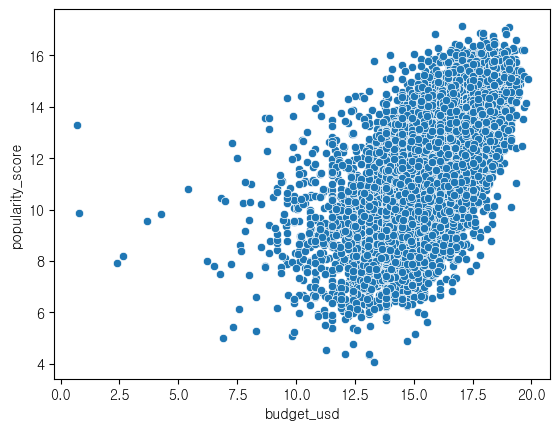

In [63]:
sns.scatterplot(x=np.log1p(df['budget_usd']), y=np.log1p(df['popularity_score']))

In [64]:
import matplotlib.pyplot as plt

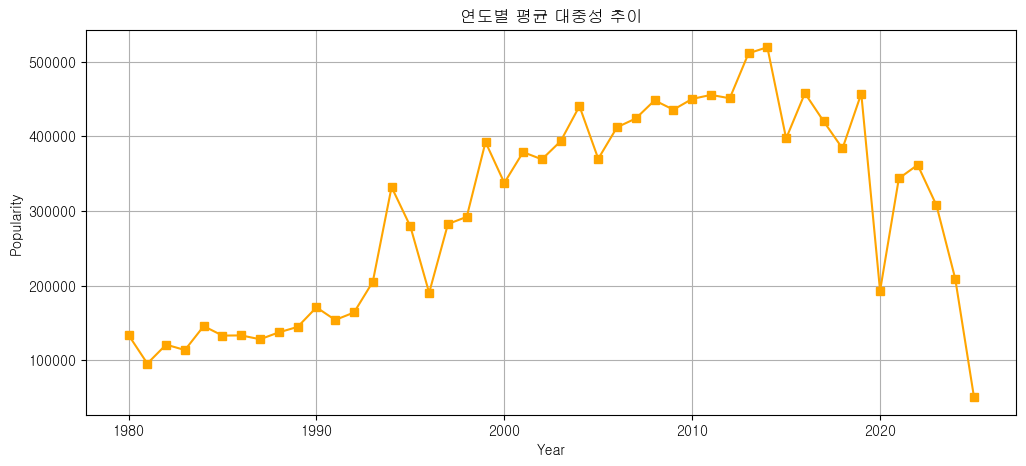

In [66]:
df.groupby('Year')['popularity_score'].mean().plot(kind='line', color='orange', marker='s', figsize=(12, 5))
plt.title('연도별 평균 대중성 추이')
plt.ylabel('Popularity')
plt.grid(True)
plt.show()


In [67]:
# 예산을 구간별로 나눔 (로그 값 기준으로 구간화)
bins = [0, 1e6, 1e7, 5e7, 1e8, 5e8]
labels = ['<1M', '1M~10M', '10M~50M', '50M~100M', '100M+']

df['budget_group'] = pd.cut(df['budget_usd'], bins=bins, labels=labels)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\2227328904.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('budget_group')['popularity_score'].mean().reset_index()


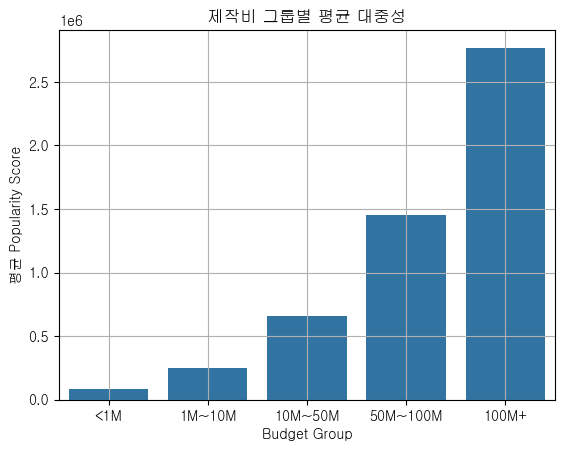

In [53]:
grouped = df.groupby('budget_group')['popularity_score'].mean().reset_index()

sns.barplot(data=grouped, x='budget_group', y='popularity_score')
plt.title('제작비 그룹별 평균 대중성')
plt.ylabel('평균 Popularity Score')
plt.xlabel('Budget Group')
plt.grid(True)
plt.show()


In [ ]:
# 제작비가 증가할 수록 평균 대중성은 증가한다.

In [70]:
df1 = df[['Title','countries_origin', 'Languages', 'Duration_minute',
       'budget_usd', 'genres_imdb', 'popularity_score']]

In [71]:
df1

,Title,countries_origin,Languages,Duration_minute,budget_usd,genres_imdb,popularity_score
0,1. Star Wars: Episode V - The Empire Strikes Back,[United States],[English],124.0,18000000.0,"[Action, Adventure, Fantasy]",12180000.0
1,2. Superman II,[United Kingdom],"[English, French, Russian]",127.0,54000000.0,"[Action, Adventure]",802400.0
2,3. 9 to 5,[United States],"[English, French]",109.0,10000000.0,[Comedy],282900.0
3,4. Stir Crazy,[United States],"[English, Spanish]",111.0,10000000.0,"[Comedy, Crime]",207700.0
4,5. Airplane!,[United States],[English],88.0,3500000.0,[Comedy],2094400.0
...,...,...,...,...,...,...,...
21515,434. The Most Beautiful Girl in the World,[Indonesia],[Indonesian],122.0,NaN,"[Comedy, Drama, Romance]",3995.5
21516,456. Like Father Like Son,[United States],[English],89.0,NaN,[Thriller],220.8
21517,493. The Baby in the Basket,[United Kingdom],[],100.0,NaN,"[Drama, Horror, Mystery]",453.6
21518,514. Diddy: The Making of a Bad Boy,[United States],[English],99.0,NaN,"[Biography, Crime, Documentary, Music]",2856.7


In [74]:
def parse_if_list_like(val):
    if isinstance(val, str) and '[' in val and ',' in val:
        return ast.literal_eval(val)
    return [val] if isinstance(val, str) else val

df1['countries_origin'] = df1['countries_origin'].apply(parse_if_list_like)
df1['Languages'] = df1['Languages'].apply(parse_if_list_like)
df1['genres_imdb'] = df1['genres_imdb'].apply(parse_if_list_like)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\2761381159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['countries_origin'] = df1['countries_origin'].apply(parse_if_list_like)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\2761381159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Languages'] = df1['Languages'].apply(parse_if_list_like)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\2761381159.py:8: SettingWithCopyWarning: 
A value is trying to

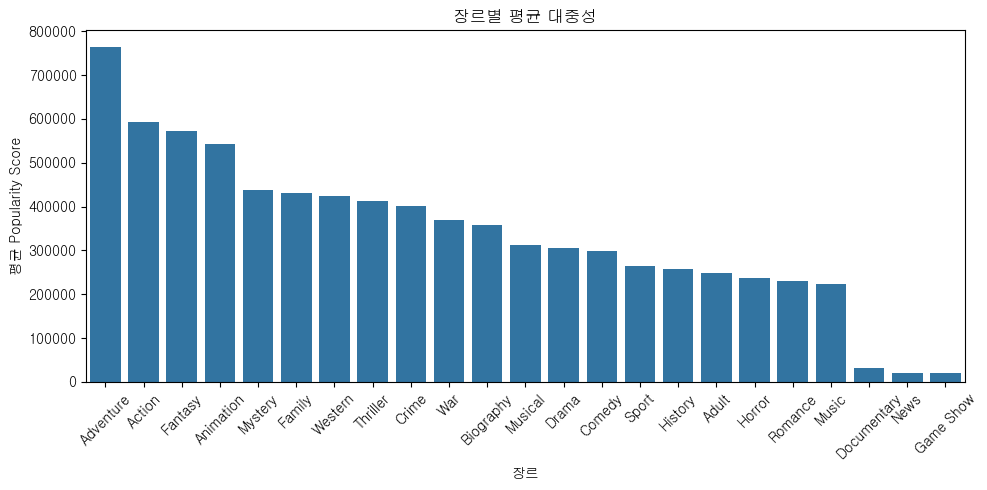

In [75]:
genre_df = df1.explode('genres_imdb')
genre_popularity = genre_df.groupby('genres_imdb')['popularity_score'].mean().sort_values(ascending=False)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values)
plt.title('장르별 평균 대중성')
plt.ylabel('평균 Popularity Score')
plt.xlabel('장르')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [81]:
# 500분 초과 영화는 이상치로 간주하고 제외
df_filtered = df1[df1['Duration_minute'] < 500]

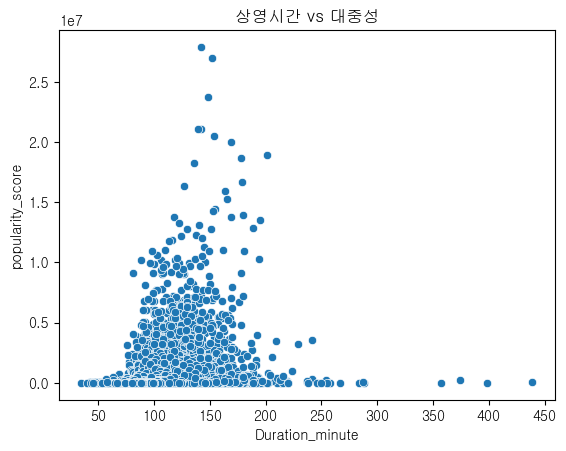

In [82]:
sns.scatterplot(x='Duration_minute', y='popularity_score', data=df_filtered)
plt.title('상영시간 vs 대중성')
plt.show()


In [83]:
# 상영시간 구간 설정 (예: 60분 단위로 나눔)
bins = [0, 60, 90, 120, 150, 180, 500]
labels = ['~60분', '60~90분', '90~120분', '120~150분', '150~180분', '180분 이상']

df_filtered['duration_group'] = pd.cut(df_filtered['Duration_minute'], bins=bins, labels=labels)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\3873634642.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['duration_group'] = pd.cut(df_filtered['Duration_minute'], bins=bins, labels=labels)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28948\3684283446.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('duration_group')['popularity_score'].mean().reset_index()


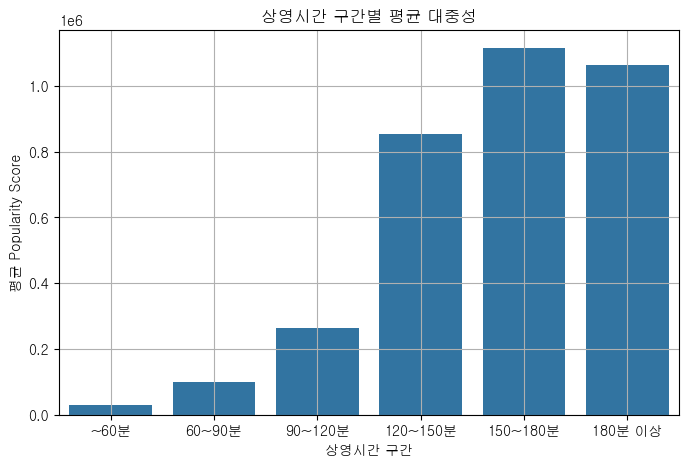

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그룹별 평균 popularity_score
grouped = df_filtered.groupby('duration_group')['popularity_score'].mean().reset_index()

# 막대 그래프
plt.figure(figsize=(8, 5))
sns.barplot(x='duration_group', y='popularity_score', data=grouped)
plt.title('상영시간 구간별 평균 대중성')
plt.xlabel('상영시간 구간')
plt.ylabel('평균 Popularity Score')
plt.grid(True)
plt.show()


# 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ▶ 예: 특성과 타깃 나누기

X = df1.drop(columns=['Title', 'countries_origin', 'Languages', 'genres_imdb'])
y = df1['popularity_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ▶ 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# ▶ 예측 및 평가
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))



RMSE: 802718634.1669414
R²: 0.9993807693420304


In [100]:
df2 = pd.read_csv('movies_1980_2025.csv')

In [101]:
df2.columns

Index(['Title', 'Year', 'MPA', 'Rating', 'Votes', 'writers', 'directors',
       'stars', 'countries_origin', 'production_company', 'Languages',
       'Duration_minute', 'budget_usd', 'genres_imdb', 'popularity_score'],
      dtype='object')

# XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [106]:
df2.columns

Index(['MPA', 'Duration_minute', 'genres_imdb', 'popularity_score'], dtype='object')

In [107]:
df2 = df2[[ 'MPA','Duration_minute', 'genres_imdb', 'popularity_score']]
df2

,MPA,Duration_minute,genres_imdb,popularity_score
0,PG,124.0,"['Action', 'Adventure', 'Fantasy']",12180000.0
1,PG,127.0,"['Action', 'Adventure']",802400.0
2,PG,109.0,['Comedy'],282900.0
3,R,111.0,"['Comedy', 'Crime']",207700.0
4,PG,88.0,['Comedy'],2094400.0
...,...,...,...,...
21515,TV-14,122.0,"['Comedy', 'Drama', 'Romance']",3995.5
21516,R,89.0,['Thriller'],220.8
21517,TV-MA,100.0,"['Drama', 'Horror', 'Mystery']",453.6
21518,TV-MA,99.0,"['Biography', 'Crime', 'Documentary', 'Music']",2856.7


In [111]:
from sklearn.preprocessing import LabelEncoder

# 예: MPA 컬럼 Label Encoding
le = LabelEncoder()
df2['MPA'] = le.fit_transform(df2['MPA'].astype(str))  # NaN 처리 포함

# 예: genres_imdb는 리스트 형태라면 MultiLabelBinarizer 사용
from sklearn.preprocessing import MultiLabelBinarizer

# 문자열 → 리스트로 먼저 변환 (예: '["Action", "Drama"]' → ['Action', 'Drama'])
import ast
df2['genres_imdb'] = df2['genres_imdb'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df2['genres_imdb']), columns=mlb.classes_)

# 원래 df에 붙이기
df2 = pd.concat([df2.drop('genres_imdb', axis=1), genre_encoded], axis=1)


In [122]:
X = df2.drop('popularity_score', axis=1)
y = df2['popularity_score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=0)

'''xgb_reg = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=0
)'''

xgb_reg = XGBRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.04,
    subsample=0.7,
    colsample_bytree=0.9,
    reg_alpha=0.5,
    reg_lambda=1.5,
    gamma=0.1,
    min_child_weight=5,
    random_state=0,
    verbosity=0
)
xgb_reg.fit(X_train, y_train)

y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))

Train RMSE: 682780575077.6217
Test RMSE: 853033548305.3857
Train MAE: 319795.67862841644
Test MAE: 355909.41242509236
Train R2: 0.3881188065646144
Test R2: 0.19685622664281655


# 최고 성능

In [137]:
X = df2.drop('popularity_score', axis=1)
y = df2['popularity_score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=0)

xgb_reg = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=0
)


xgb_reg.fit(X_train, y_train)

y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))

Train RMSE: 802445402672.8171
Test RMSE: 825559697694.8632
Train MAE: 336500.4334591944
Test MAE: 354922.1002214533
Train R2: 0.28087987769956324
Test R2: 0.2227232656260093


# LightGBM Regressor

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

In [152]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X = df2.drop('popularity_score', axis=1)
y = df2['popularity_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lgb_reg = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,           # 더 얕게
    num_leaves=32,         # 복잡도 줄이기
    min_child_samples=20,  # 과적합 방지
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,         # L1 정규화 추가
    reg_lambda=1.0,        # L2 정규화 추가
    random_state=0
)

lgb_reg.fit(X_train, y_train)

y_pred_train = lgb_reg.predict(X_train)
y_pred_test = lgb_reg.predict(X_test)

print("Train RMSE:", mean_squared_error(y_train, y_pred_train))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))


Train RMSE: 766933713487.32
Test RMSE: 820621020146.5897
Train MAE: 328865.94567182584
Test MAE: 352627.2554182345
Train R2: 0.31270406185602995
Test R2: 0.22737310399332133
